In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
print("Tensorflow Version: ", tf.__version__)
from statsmodels.tsa.arima_model import ARIMA

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
#from pmdarima.arima.utils import ndiffs
from numpy import log
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

Tensorflow Version:  2.12.0


In [ ]:
df = pd.read_csv('USDC-USD.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-10-08,1.00410,1.00768,1.00190,1.00221,1.00221,382900
1,2018-10-09,1.00427,1.00833,1.00003,1.00686,1.00686,108803
2,2018-10-10,1.00494,1.01908,1.00397,1.00962,1.00962,711783
3,2018-10-11,1.00994,1.03123,1.00173,1.00978,1.00978,4177290
4,2018-10-12,1.00861,1.01871,1.00114,1.01272,1.01272,1322240


## Pre-processing

### Time Selection

In [ ]:
def line_plot(line1, line2, title, lw=2):
  plt.figure(figsize=(16, 8), dpi=150)

  line1.plot(label='Before', color='orange')
  line2.plot(label='After', color='blue')

  plt.title(title)
  plt.xlabel('Year')
  plt.ylabel('Price')
  plt.legend()

In [ ]:
# date as index
df = df.set_index('Date')
df.index = pd.to_datetime(df.index, unit='ns')

In [ ]:
old_df = df
df = df.loc['2021-01-01':]

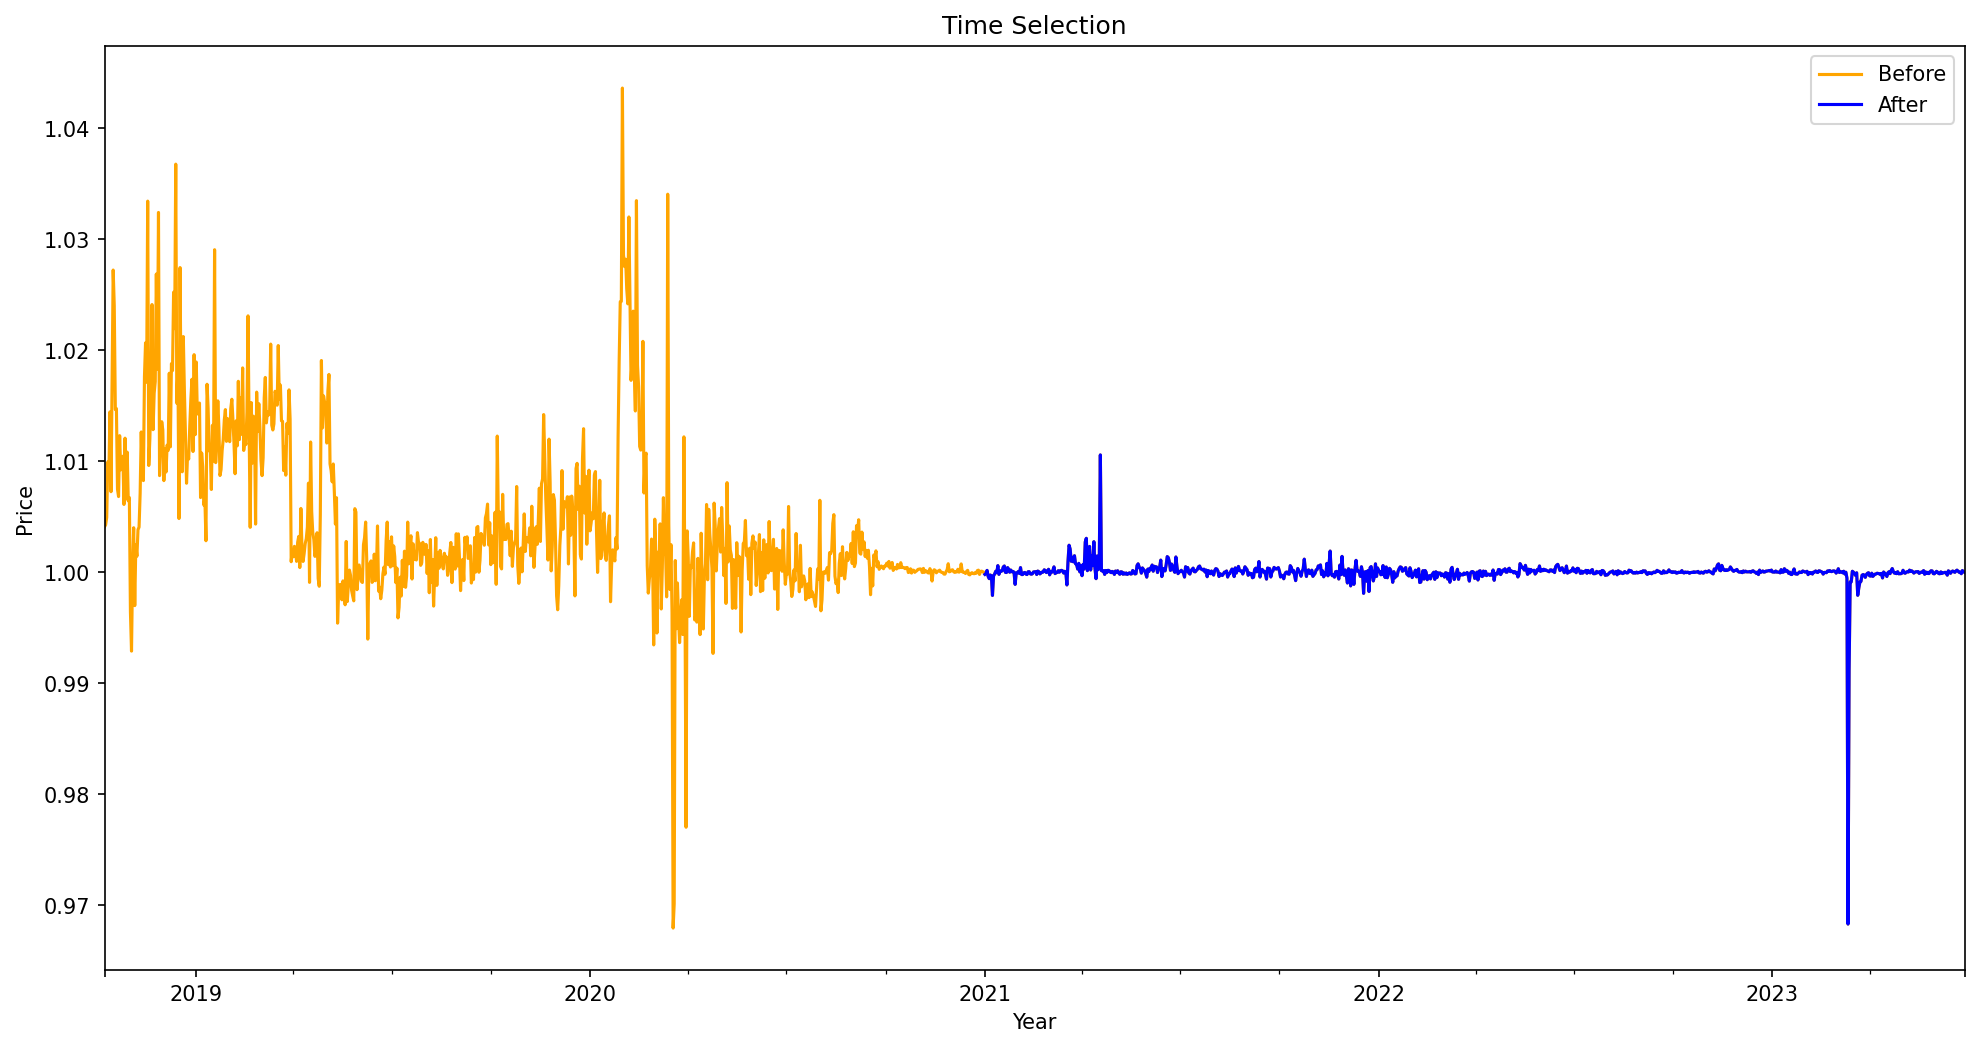

In [ ]:
line_plot(old_df['Open'], df['Open'], 'Time Selection')

### One hot encoding

In [ ]:
# creating status columns with one hot encoding (up and down)
down = []
up = []

for x in range(len(df.Close)):
  if x == 0:
    up.append(0)
    down.append(1)
  elif df.Open[x-1] < df.Open[x]:
    up.append(1)
    down.append(0)
  else:
    up.append(0)
    down.append(1)

df['Down'] = down
df['Up'] = up

In [ ]:
df.head()

,Open,High,Low,Close,Adj Close,Volume,Down,Up
Date,,,,,,,,
2018-10-08,1.00410,1.00768,1.00190,1.00221,1.00221,382900,1,0
2018-10-09,1.00427,1.00833,1.00003,1.00686,1.00686,108803,0,1
2018-10-10,1.00494,1.01908,1.00397,1.00962,1.00962,711783,0,1
2018-10-11,1.00994,1.03123,1.00173,1.00978,1.00978,4177290,0,1
2018-10-12,1.00861,1.01871,1.00114,1.01272,1.01272,1322240,1,0


### Feature Selection

In [ ]:
# selecting the correct data and eliminating unwanted info
desired_columns = ['Open', 'High', 'Low', 'Close']
target_columns = ['Down', 'Up']

feature = df[desired_columns]
target = df[target_columns]

### Windowning

In [ ]:
def Window(df):
  window = []
  for i in range(0,len(df)):
    if i+4 < len(df):
      window.append([*df.values[i], *df.values[i+1], *df.values[i+2], *df.values[i+3]])
  return window

In [ ]:
window_feature = Window(feature)
target.drop(['2018-10-08', '2018-10-09', '2018-10-10', '2018-10-11'], axis=0, inplace=True)

<ipython-input-15-1647f6a63994>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  target.drop(['2018-10-08', '2018-10-09', '2018-10-10', '2018-10-11'], axis=0, inplace=True)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(window_feature, target, test_size=0.2, shuffle=False)

### Min-max normalization


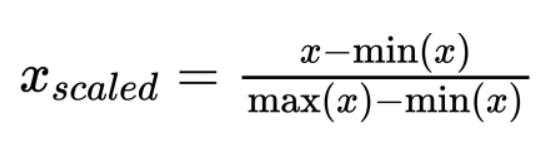

In [ ]:
# os dados de teste foram normalizados com o minimo e maximo dos dados de treinamento

scaler = preprocessing.MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
print('Min train: ', X_train_scaled.min(axis=0))
print('Min test: ', X_test_scaled.min(axis=0))
print('Max train: ', X_train_scaled.max(axis=0))
print('Max test: ', X_test_scaled.max(axis=0))

Min train:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Min test:  [ 0.00478273 -0.00336473 -0.55226139  0.0186185   0.00478273 -0.00336473
 -0.55226139  0.0186185   0.00478273 -0.00336473 -0.55226139  0.0186185
  0.00478273 -0.00336473 -0.55226139  0.0186185 ]
Max train:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Max test:  [0.43361651 0.00545647 0.75468903 0.41418037 0.43361651 0.00545647
 0.75468903 0.41418037 0.43361651 0.00545647 0.75468903 0.41418037
 0.43361651 0.00545647 0.75468903 0.41418037]


## Models

### MLP

In [ ]:
def MLP (hidden_layers, neurons, learning_rate):
  MLP_model = tf.keras.models.Sequential()

  for i in range(hidden_layers):
    layer = tf.keras.layers.Dense(neurons, activation='relu')
    MLP_model.add(layer)

  output_layer = tf.keras.layers.Dense(2, activation='softmax')
  MLP_model.add(output_layer)

  MLP_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss=tf.keras.losses.BinaryCrossentropy(), metrics=['categorical_accuracy'])

  return MLP_model

In [ ]:
# discretizando o output (definindo qual seria o status dele)
def status(y_pred):
  status = []
  for x in range(len(y_pred)):
    if (y_pred[x][0] > y_pred[x][1]):
      status.append(0) # down
    else:
      status.append(1) # up
  return status

### LSTM

Precisamos formatar os dados para a entrada aceita pela camada LSTM, i.e. converter de 2D para 3D

A entrada para a camada LSTM é representada da seguinte forma:

<center>(amostras, qtde de entradas, tamanho do vetor de entrada)</center>

In [ ]:
# reshaping the features

X_train_scaled = X_train_scaled.reshape(X_train_scaled.shape[0], 1, X_train_scaled.shape[1])
X_test_scaled = X_test_scaled.reshape(X_test_scaled.shape[0], 1, X_test_scaled.shape[1])

y_train = y_train.values.reshape(y_train.shape[0], 1, y_train.shape[1])
y_test = y_test.values.reshape(y_test.shape[0], 1, y_test.shape[1])

In [ ]:
def LSTM (hidden_layers, neurons, learning_rate):

  LSTM_model = tf.keras.models.Sequential()

  for i in range(hidden_layers):
    LSTM_layer = tf.keras.layers.LSTM(neurons, return_sequences=True)
    LSTM_model.add(LSTM_layer)

  output_layer = tf.keras.layers.Dense(2, activation='softmax')
  LSTM_model.add(output_layer)

  LSTM_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss=tf.keras.losses.BinaryCrossentropy(), metrics=['categorical_accuracy'])

  return LSTM_model

## Optimization

### Increasing Window Cross Validation

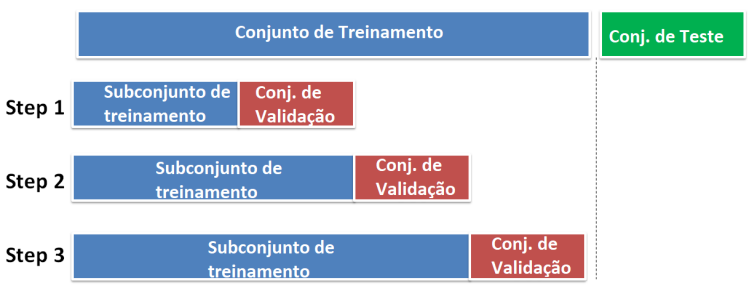

Provides train/test indices to split time series data samples that are observed at fixed time intervals, in train/test sets. In each split, test indices must be higher than before

*Parameters*

- n_splits: Number of splits

- max_train_size: Maximum size for a single training set

- test_size: Used to limit the size of the test set

- gap: Number of samples to exclude from the end of each train set before the test set

**OBS**: The training set has size <br><center>i * n_samples // (n_splits + 1) + n_samples % (n_splits + 1)</center></br> in the i th split, with a test set of size <br><center>n_samples//(n_splits + 1)</center></br> by default, where n_samples is the number of samples

In [ ]:
def iwcv (model, X_train, y_train): # o erro estará associado com a falta ou presença do iloc no y_train e com a função status lá encima
  tscv = TimeSeriesSplit(n_splits=5)
  metrics = []

  for idx_train, idx_validation in tscv.split(X_train):
    model.fit(X_train[idx_train], y_train[idx_train], epochs=200)
    y_pred = model.predict(X_train[idx_validation])
    f1 = f1_score(status(y_train[idx_validation]), status(y_pred))
    val_loss, val_acc = model.evaluate(X_train[idx_validation], y_train[idx_validation])
    metrics.append([f1, val_acc, len(X_train[idx_train]), len(X_train[idx_validation])])

  return metrics

In [ ]:
def avg (metrics):
  avg_f1 = []
  avg_acc = []

  for i,j in enumerate(metrics):
    avg_f1.append(j[0])
    avg_acc.append(j[1])

  avg_f1 = sum(avg_f1)/len(avg_f1)
  avg_acc = sum(avg_acc)/len(avg_acc)

  return avg_f1, avg_acc

### Grid Search

In [ ]:
def grid_search (model, hidden_layers, neurons, learning_rate):
  parameters = []

  if (model == MLP):
    for i in hidden_layers:
      for j in neurons:
        for k in learning_rate:
          print(j)
          model = MLP(i,j,k)
          metrics = iwcv(model, X_train_scaled, y_train)
          avg_f1, avg_acc = avg(metrics)
          parameters.append([i,j,k,metrics,avg_f1,avg_acc])
  elif (model == LSTM):
    for i in hidden_layers:
      for j in neurons:
        for k in learning_rate:
          print(j)
          model = LSTM(i,j,k)
          metrics = iwcv(model, X_train_scaled, y_train)
          avg_f1, avg_acc = avg(metrics)
          parameters.append([i,j,k,metrics,avg_f1,avg_acc])
  else:
    print("Selecione um modelo válido")

  return parameters

In [ ]:
# reshaping

X_train_scaled = X_train_scaled.reshape(X_train_scaled.shape[0], X_train_scaled.shape[2])
X_test_scaled = X_test_scaled.reshape(X_test_scaled.shape[0], X_test_scaled.shape[2])

y_train = y_train.reshape(y_train.shape[0], y_train.shape[2])
y_test = y_test.reshape(y_test.shape[0], y_test.shape[2])

In [ ]:
hidden_layers = [1,2,3,4]
neurons = [10,30,50,70]
learning_rate = [0.001, 0.005, 0.01]
parameters = grid_search(MLP, hidden_layers, neurons, learning_rate)

Streaming output truncated to the last 5000 lines.
22/22 [==============================] - 0s 6ms/step - loss: 0.1384 - categorical_accuracy: 0.9463
Epoch 116/200
22/22 [==============================] - 0s 6ms/step - loss: 0.1065 - categorical_accuracy: 0.9652
Epoch 117/200
22/22 [==============================] - 0s 5ms/step - loss: 0.1129 - categorical_accuracy: 0.9594
Epoch 118/200
22/22 [==============================] - 0s 5ms/step - loss: 0.2722 - categorical_accuracy: 0.8766
Epoch 119/200
22/22 [==============================] - 0s 6ms/step - loss: 0.1927 - categorical_accuracy: 0.9231
Epoch 120/200
22/22 [==============================] - 0s 6ms/step - loss: 0.1500 - categorical_accuracy: 0.9376
Epoch 121/200
22/22 [==============================] - 0s 6ms/step - loss: 0.1990 - categorical_accuracy: 0.9187
Epoch 122/200
22/22 [==============================] - 0s 6ms/step - loss: 0.2123 - categorical_accuracy: 0.9042
Epoch 123/200
22/22 [==============================] - 0s 6

In [ ]:
parameters

[[1,
  10,
  0.001,
  [[0.7713004484304934, 0.7772925496101379, 231, 229],
   [0.8502024291497975, 0.8384279608726501, 460, 229],
   [0.8, 0.7467249035835266, 689, 229],
   [0.7073954983922829, 0.6026200652122498, 918, 229],
   [0.4109589041095891, 0.624454140663147, 1147, 229]],
  0.7079714560164325,
  0.7179039239883422],
 [1,
  10,
  0.005,
  [[0.8833333333333334, 0.8777292370796204, 231, 229],
   [0.9327731092436974, 0.9301310181617737, 460, 229],
   [0.8465116279069766, 0.8558952212333679, 689, 229],
   [0.9107981220657277, 0.9170305728912354, 918, 229],
   [0.7945205479452054, 0.7379912734031677, 1147, 229]],
  0.8735873480989881,
  0.863755464553833],
 [1,
  10,
  0.01,
  [[0.9180327868852458, 0.9126637578010559, 231, 229],
   [0.9391304347826087, 0.9388646483421326, 460, 229],
   [0.7922705314009661, 0.8122270703315735, 689, 229],
   [0.4583333333333333, 0.6593886613845825, 918, 229],
   [0.7160493827160493, 0.5982532501220703, 1147, 229]],
  0.7647632938236407,
  0.78427947759

### Analyzing Hiperparemeters Results

In [ ]:
df_parameters = pd.DataFrame(parameters, columns=['hidden_layers', 'neurons', 'learning_rate', 'metrics', 'f1_score_avg', 'acuracy_avg'])
df_parameters

,hidden_layers,neurons,learning_rate,metrics,f1_score_avg,acuracy_avg
0,1,10,0.001,"[[0.7713004484304934, 0.7772925496101379, 231,...",0.707971,0.717904
1,1,10,0.005,"[[0.8833333333333334, 0.8777292370796204, 231,...",0.873587,0.863755
2,1,10,0.010,"[[0.9180327868852458, 0.9126637578010559, 231,...",0.764763,0.784279
3,1,30,0.001,"[[0.9024390243902439, 0.8951964974403381, 231,...",0.881964,0.864629
4,1,30,0.005,"[[0.9280000000000002, 0.9213973879814148, 231,...",0.872350,0.857642
5,1,30,0.010,"[[0.8872727272727273, 0.864628791809082, 231, ...",0.786949,0.795633
6,1,50,0.001,"[[0.855072463768116, 0.8253275156021118, 231, ...",0.861851,0.842795
7,1,50,0.005,"[[0.8372093023255813, 0.847161591053009, 231, ...",0.869472,0.864629
8,1,50,0.010,"[[0.9224806201550388, 0.9126637578010559, 231,...",0.767327,0.793013
9,1,70,0.001,"[[0.8776371308016878, 0.8733624219894409, 231,...",0.798569,0.836681


In [ ]:
df_parameters.to_csv('MLP_USDC_parameters.csv')

## Metrics

### Confusion Matrix

In [ ]:
MLP_model = MLP(2,30,0.01)
MLP_model.fit(X_train_scaled, y_train, epochs=200)
y_pred = MLP_model.predict(X_test_scaled)

Epoch 1/200
45/45 [==============================] - 1s 2ms/step - loss: 0.6941 - categorical_accuracy: 0.5290
Epoch 2/200
45/45 [==============================] - 0s 2ms/step - loss: 0.6928 - categorical_accuracy: 0.5163
Epoch 3/200
45/45 [==============================] - 0s 2ms/step - loss: 0.6917 - categorical_accuracy: 0.5248
Epoch 4/200
45/45 [==============================] - 0s 2ms/step - loss: 0.6920 - categorical_accuracy: 0.5234
Epoch 5/200
45/45 [==============================] - 0s 2ms/step - loss: 0.6925 - categorical_accuracy: 0.5184
Epoch 6/200
45/45 [==============================] - 0s 2ms/step - loss: 0.6920 - categorical_accuracy: 0.5305
Epoch 7/200
45/45 [==============================] - 0s 2ms/step - loss: 0.6924 - categorical_accuracy: 0.5135
Epoch 8/200
45/45 [==============================] - 0s 2ms/step - loss: 0.6944 - categorical_accuracy: 0.5078
Epoch 9/200
45/45 [==============================] - 0s 2ms/step - loss: 0.6927 - categorical_accuracy: 0.5297
E

In [ ]:
f1 = f1_score(status(y_test), status(y_pred))
f1

0.8181818181818181

In [ ]:
val_loss, val_acc = MLP_model.evaluate(X_test_scaled, y_test)

12/12 [==============================] - 0s 2ms/step - loss: 0.2824 - categorical_accuracy: 0.8527


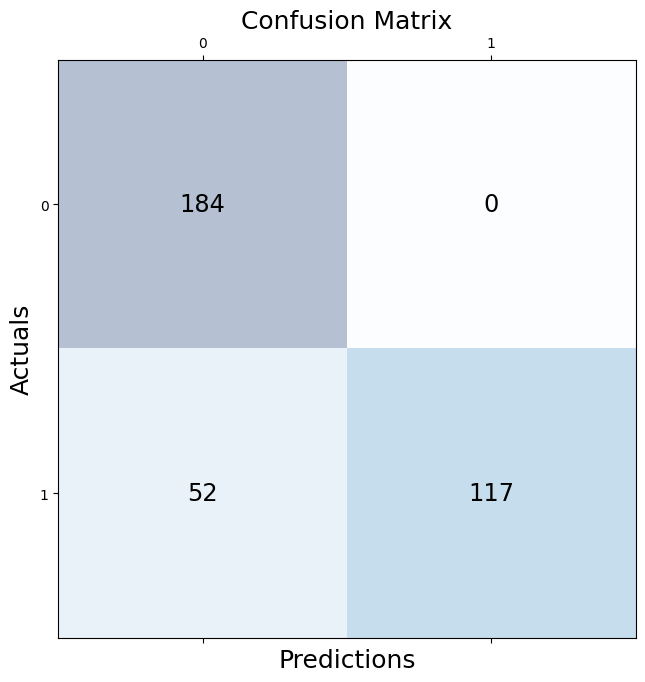

In [ ]:
# convert to numpy only in the first run
#y_test = y_test.to_numpy(dtype='float32')
conf_matrix = confusion_matrix(status(y_test), status(y_pred))

fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')

plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [ ]:
LSTM_model = LSTM(1,50,0.05)
LSTM_model.fit(X_train_scaled, y_train, epochs=200)
y_pred = LSTM_model.predict(X_test_scaled)

Epoch 1/200
45/45 [==============================] - 6s 3ms/step - loss: 0.7003 - categorical_accuracy: 0.4908
Epoch 2/200
45/45 [==============================] - 0s 3ms/step - loss: 0.6933 - categorical_accuracy: 0.5312
Epoch 3/200
45/45 [==============================] - 0s 3ms/step - loss: 0.6949 - categorical_accuracy: 0.4752
Epoch 4/200
45/45 [==============================] - 0s 3ms/step - loss: 0.6945 - categorical_accuracy: 0.5234
Epoch 5/200
45/45 [==============================] - 0s 3ms/step - loss: 0.6927 - categorical_accuracy: 0.5106
Epoch 6/200
45/45 [==============================] - 0s 3ms/step - loss: 0.6925 - categorical_accuracy: 0.5305
Epoch 7/200
45/45 [==============================] - 0s 3ms/step - loss: 0.6944 - categorical_accuracy: 0.5057
Epoch 8/200
45/45 [==============================] - 0s 3ms/step - loss: 0.6958 - categorical_accuracy: 0.4936
Epoch 9/200
45/45 [==============================] - 0s 3ms/step - loss: 0.6934 - categorical_accuracy: 0.5078
E

In [ ]:
f1 = f1_score(status(y_test), status(y_pred))
f1

0.9068322981366459

In [ ]:
val_loss, val_acc = LSTM_model.evaluate(X_test_scaled, y_test)

12/12 [==============================] - 0s 3ms/step - loss: 0.1810 - categorical_accuracy: 0.9150


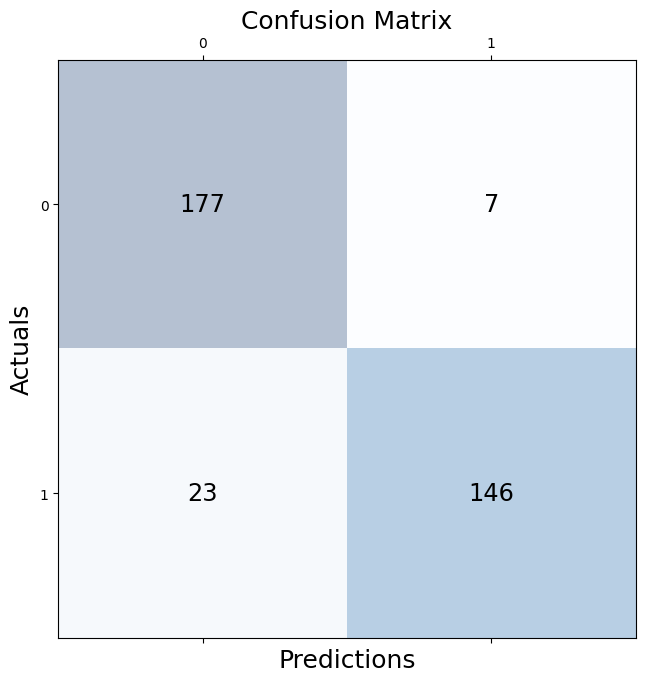

In [ ]:
# convert to numpy only in the first run
#y_test = y_test.to_numpy(dtype='float32')
conf_matrix = confusion_matrix(status(y_test), status(y_pred))

fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')

plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

### ARIMA

#### Finding p,d,q

In [ ]:
result = adfuller(pd.DataFrame(df.values.reshape(-1).tolist()).dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -4.876589
p-value: 0.000039


/usr/local/lib/python3.10/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


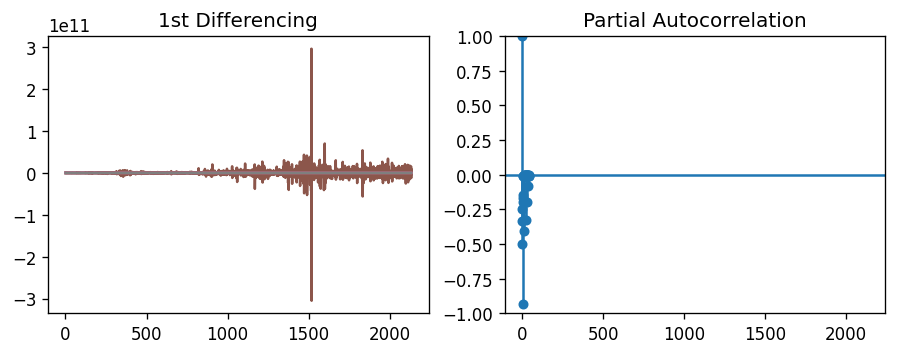

In [ ]:
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(pd.DataFrame(df.values).diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,5))
plot_pacf(pd.DataFrame(df.values.reshape(-1).tolist()).diff().dropna(), ax=axes[1])

plt.show()

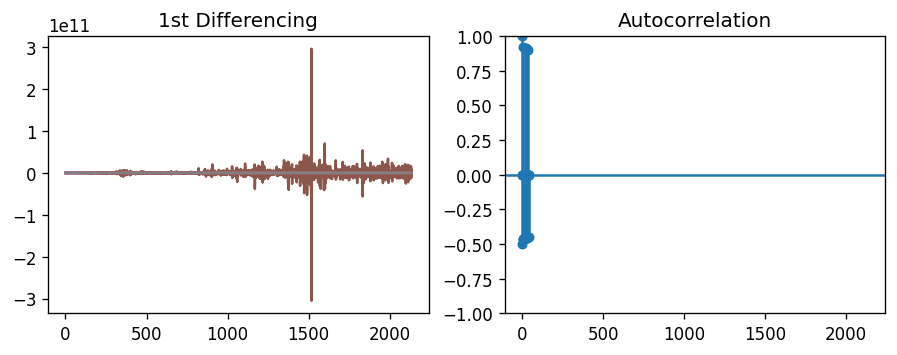

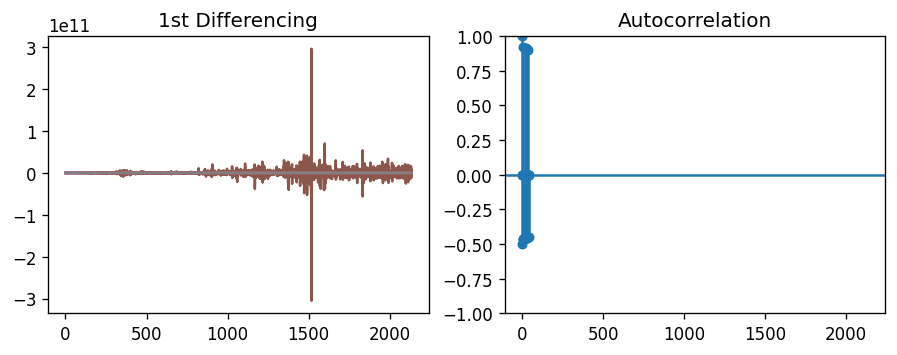

In [ ]:
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(pd.DataFrame(df.values).diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,1.2))
plot_acf(pd.DataFrame(df.values.reshape(-1).tolist()).diff().dropna(), ax=axes[1])


In [ ]:
ARIMA_model = ARIMA(df.values, order=(1,1,2))
ARIMA_model_fit = ARIMA_model.fit(disp=0)
print(ARIMA_model_fit.summary())

NotImplementedError: ignored